<a href="https://colab.research.google.com/github/iamabhinav13/fraud-detection/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary libraries

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading the data

In [4]:
df = pd.read_csv('/content/SyntheticFinancialData.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Basic Overview

In [8]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

### Check for Missing Values

In [9]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Distribution of Transactions

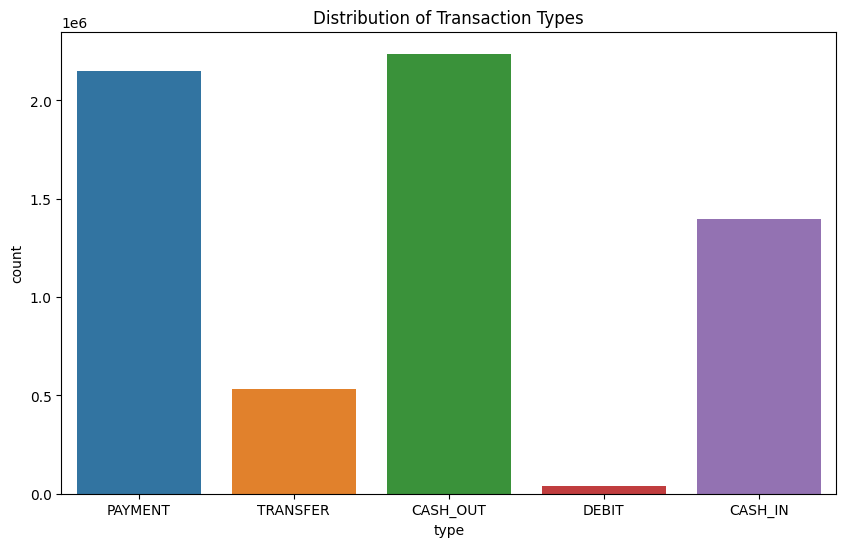

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Distribution of Transaction Types')
plt.show()

### Amount Distribution

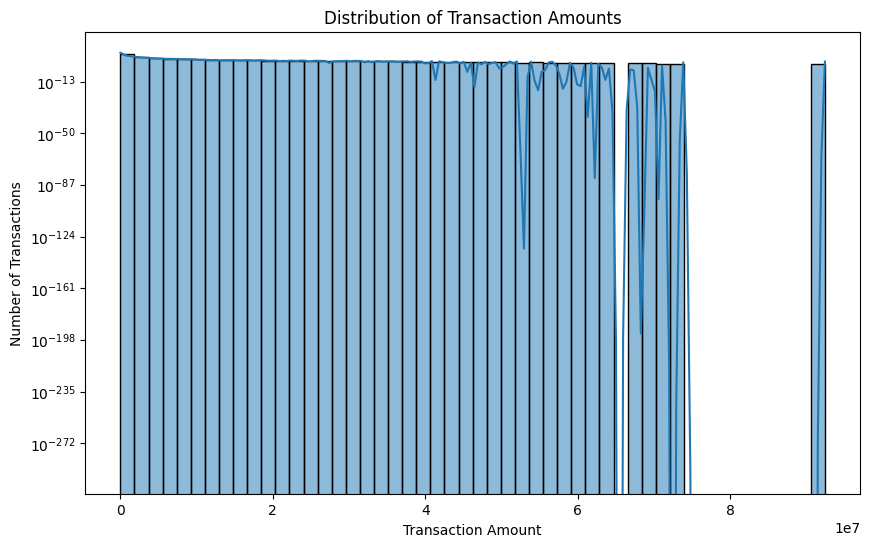

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

### Fraud Transactions vs. Legitimate Transactions

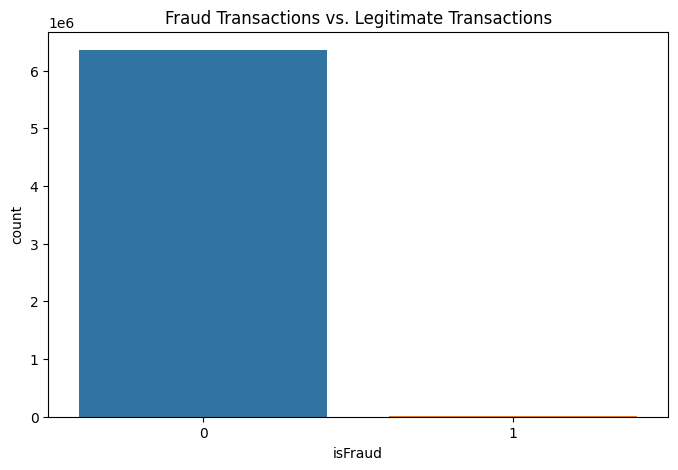

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud Transactions vs. Legitimate Transactions')
plt.show()

### Correlation Matrix

<ipython-input-16-89574a6cafce>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


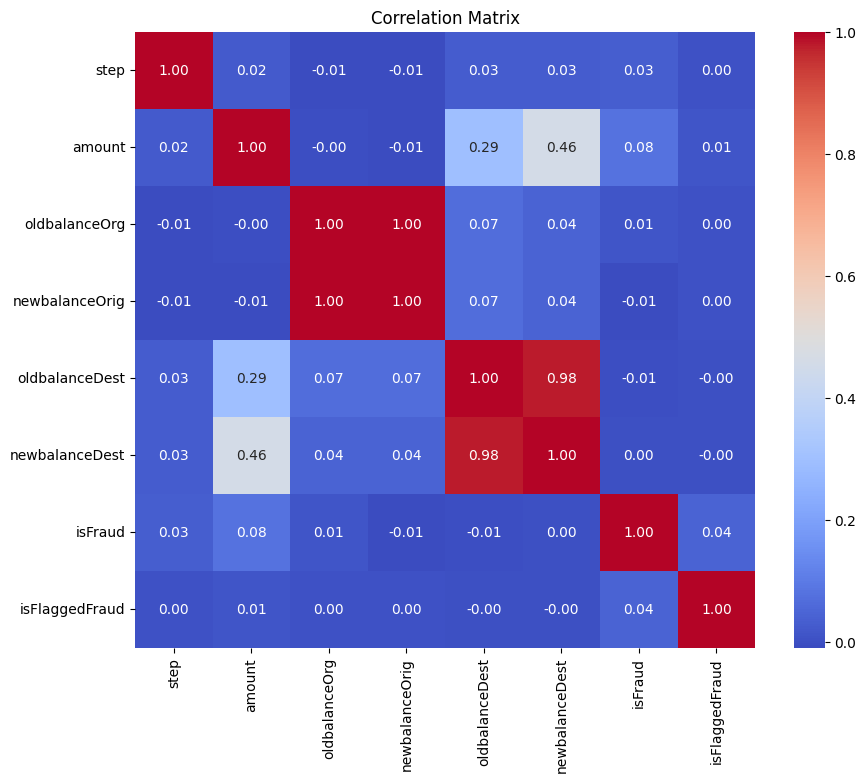

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



Here are some of the inferences that can be drawn from the plot:

*  There is a strong positive correlation between amount and newbalanceDest (0.46). This means that as the amount of money transferred increases, the new balance in the destination account also increases.

*  There is a strong positive correlation between oldbalanceDest and newbalanceDest (0.98). This means that the old balance in the destination account is a good predictor of the new balance after the transfer.

*  There is a weak negative correlation between isFraud and amount (-0.08). This means that there is a slight tendency for fraudulent transactions to involve smaller amounts of money.

*  There is no correlation between isFraud and isFlaggedFraud (0.00). This means that whether or not a transaction is flagged as fraudulent is not related to whether or not it is actually fraudulent.



### Transaction Type vs. Fraud

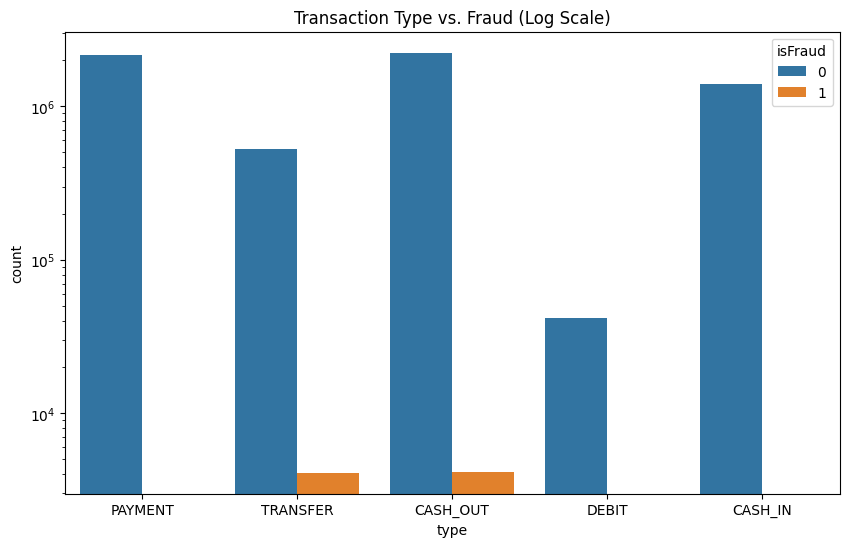

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.yscale('log')
plt.title('Transaction Type vs. Fraud (Log Scale)')
plt.show()

From this we can see that, the fraudulent cases are in only two categories of transaction that is, Transfer and Cash Out.

### Amount vs. Fraud

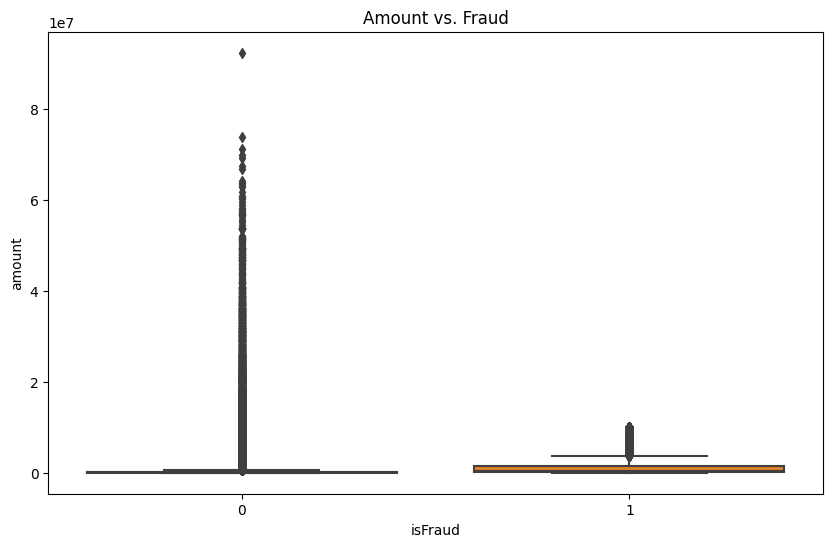

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Amount vs. Fraud')
plt.show()

### Balance Discrepancies

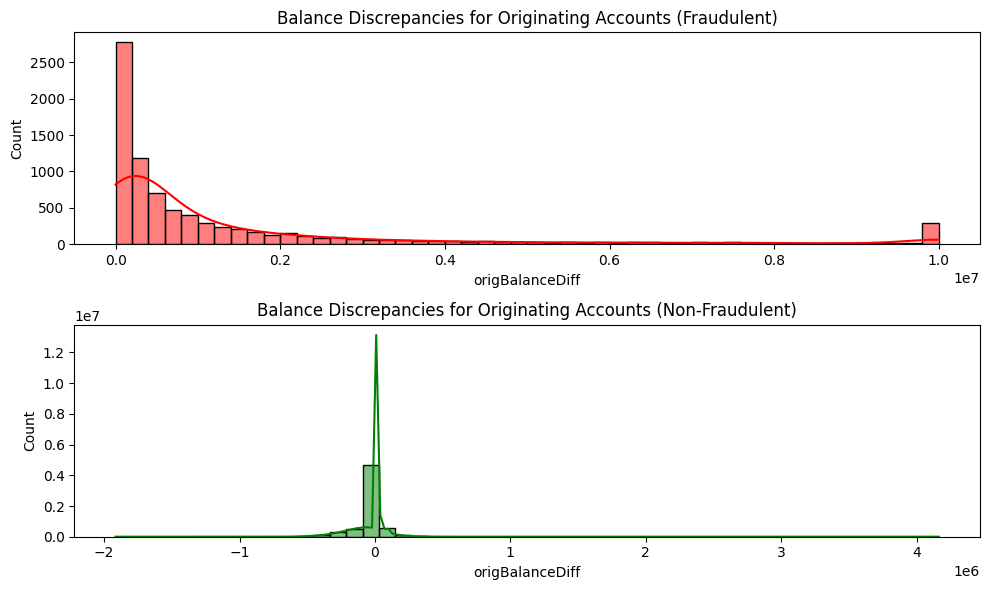

In [23]:
# Calculate balance discrepancies for originating and destination accounts
df['origBalanceDiff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['destBalanceDiff'] = df['oldbalanceDest'] - df['newbalanceDest']

# Separate fraudulent and non-fraudulent transactions
fraudulent = df[df['isFraud'] == 1]
non_fraudulent = df[df['isFraud'] == 0]

# Plotting balance discrepancies for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.histplot(fraudulent['origBalanceDiff'], bins=50, kde=True, color='red')
plt.title('Balance Discrepancies for Originating Accounts (Fraudulent)')

plt.subplot(2, 1, 2)
sns.histplot(non_fraudulent['origBalanceDiff'], bins=50, kde=True, color='green')
plt.title('Balance Discrepancies for Originating Accounts (Non-Fraudulent)')

plt.tight_layout()
plt.show()